# Part 2

### Numbers

As the images are already binarized, I will not do any pre-processing. 

In the code block below, I have **resize** the images so that they have a common size (I choose $100\times100$). This action will allow to apply a Euclidean distance between all the images without encountering dimensional problems later on.  


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
import skimage
import numpy as np 

from os import listdir
from os.path import isfile, join
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
from skimage.util import invert

def seuillage(image, seuil):
    n = np.shape(image)
    if (len(n) == 3) : 
        image = image * 255
        image[image < seuil] = 0.
        image[image >= seuil] = 255.
        image = image / 255
    else : 
        image[image < seuil] = 0.
        image[image >= seuil] = 255.
    return image

images = [f for f in listdir('numbers/') if isfile(join('numbers/', f))]

l = []
for im in images:
    ima = io.imread('numbers/' + im)
    image = resize(ima, (100,100), anti_aliasing=True)
    image = seuillage(image, 0.5)
    l.append(image)
 
zeros1 = l[2]; zeros2 = l[9]; zeros3 = l[6]
one1 = l[11]; one2 = l[0]; one3 = l[7]
two1 = l[8]; two2 = l[10]; two3 = l[3]
three1 = l[5]; three2 = l[1]; three3 = l[4]
list_im = [zeros1, zeros2, zeros3, one1, one2, one3, two1, two2, two3, three1, three2, three3]

## Image intensity


First, we will compare the images with their raw pixel intensities. 

This descriptor has a length of 10000 (number of variables = 10000, here it is the number of pixels in the image (100x100))

We can think that this descriptor will be pretty bad. 

Let's see the result, below, with the comparison (Euclidean distance) between all the numbers: 



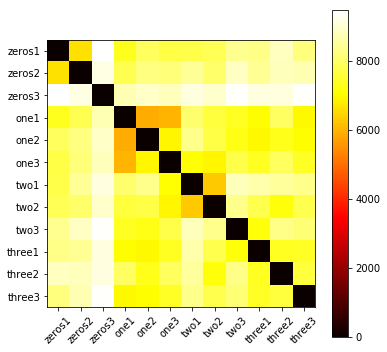

In [3]:
from scipy.spatial.distance import euclidean

# Compute a 1d Vector for the image (necessary to compute the euclidean distance)
def d1_vect(image):
    res = 1
    dim = len(image.shape)
    for i in range(dim): 
        res = res * image.shape[i]
    im = image.reshape(res,)
    return im 

# Function to compute mapping matrix
def mapping(list_im):
    m = np.zeros((len(list_im),len(list_im)))

    for i in range(len(list_im)): 
        for j in range(len(list_im)): 
            im1 = d1_vect(list_im[i])
            im2 = d1_vect(list_im[j])
            m[i][j] = euclidean(im1,im2)
    return m


# Fucntion to plot mapping matrix
def plot_mapping(m, labels):
    figure = plt.figure(figsize=(6,6))
    axes = figure.add_subplot(111)

    axes.xaxis.set_ticks(range(len(labels)))
    axes.yaxis.set_ticks(range(len(labels)))
    axes.xaxis.set_ticklabels(labels, rotation=45)
    axes.yaxis.set_ticklabels(labels)
    plt.imshow(m, cmap='hot')
    plt.colorbar()
    plt.show()
    
#Plot 
labels = ['zeros1', 'zeros2', 'zeros3', 'one1', 'one2', 'one3', 'two1', 'two2', 'two3', 'three1', 'three2', 'three3']
m = mapping(list_im)
plot_mapping(m, labels)

We can notice that this descriptor is indeed not efficient. For the 1 it's not bad but it doesn't allow to differentiate the same numbers otherwise....  

## Not SIFT but ORB

The SIFT method is not really implemented in skimage. We will therefore use ORB (Oriented FAST and rotated BRIEF feature detector and binary descriptor extractor).

FAST is a méthod of choice for finding keypoint that match visual features. It's efficent and finds reasonable corner keypoints (with Harris Corner).

FAST does not include an orientation operator (SIFT does with hostograms of gradients). 

BRIEF is a descriptor thaht uses simple binary tests between pixels in a smoothed image patch. Its perfortmance is similar to SIFT. 

In the ORB skimage method, we have to chose the parameter n_keypoint (Number of keypoints to be returned. The function will return the best n_keypoints according to the Harris corner response if more than n_keypoints are detected. If not, then all the detected keypoints are returned, source : skimage doc).

This means that we will choose the number of variables for our descriptor.  

In our case, which number of keypoints to choose ? The more we have, the better ?   

To find out, I tested with 3 n_keypoints of different sizes (5, 40, 73). 73 is the maximum number of keypoints found, it's the limit.  
 

With 5 keypoints :


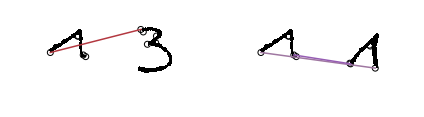

1 matches			2 matches


With 40 keypoints :


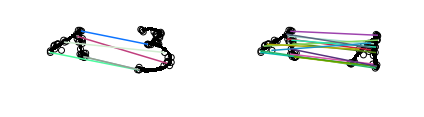

6 matches			15 matches


With 73 keypoints :


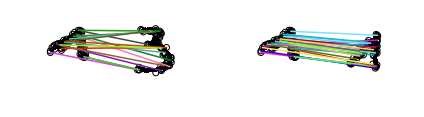

16 matches			29 matches




In [4]:
from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

k_pts_values = [5, 40, 73]

for i in k_pts_values: 
    img1 = one1
    img2 = three1
    img3 = one3

    descriptor_extractor = ORB(n_keypoints=i)

    descriptor_extractor.detect_and_extract(img1)
    keypoints1 = descriptor_extractor.keypoints
    descriptors1 = descriptor_extractor.descriptors

    descriptor_extractor.detect_and_extract(img2)
    keypoints2 = descriptor_extractor.keypoints
    descriptors2 = descriptor_extractor.descriptors

    descriptor_extractor.detect_and_extract(img3)
    keypoints3 = descriptor_extractor.keypoints
    descriptors3 = descriptor_extractor.descriptors

    matches12 = match_descriptors(descriptors1, descriptors2, metric='euclidean')
    matches13 = match_descriptors(descriptors1, descriptors3, metric='euclidean')


    fig, ax = plt.subplots(nrows=1, ncols=2)

    plt.gray()
    print('With ' + str(i) + ' keypoints :')

    plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
    ax[0].axis('off')

    plot_matches(ax[1], img1, img3, keypoints1, keypoints3, matches13)
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()
    
    print(str(len(matches12)) + ' matches\t\t\t' + str(len(matches13)) + ' matches\n\n')

We see that the circles represent the keypoints. And that the lines mean that there is a match between two points. FOr example, in the image from top left, there are only 1 matches between the 1 and the 3. 

Below, we will take all the keypoints found and we will make the Euclidean distance between them.

But, it might have been wise to take only the number of matches between two images to compare the figures. 

With 5 keypoints :


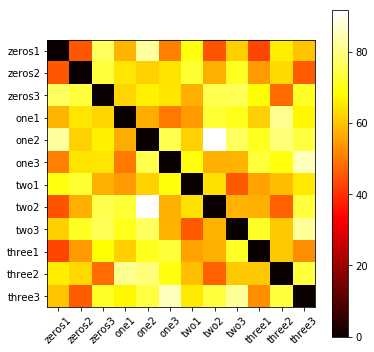

With 40 keypoints :


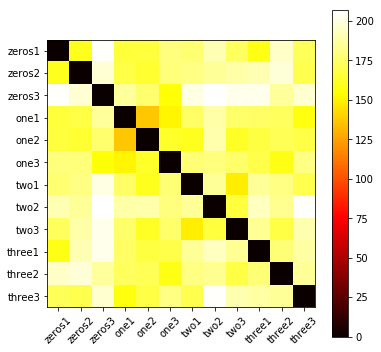

With 73 keypoints :


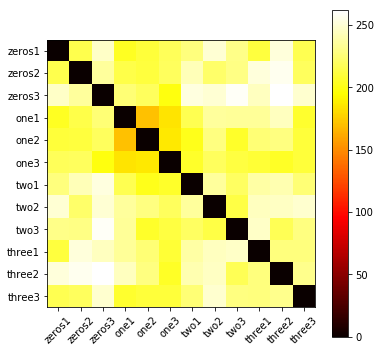

In [5]:
# Euclidean distance between all keypoints found 
for i in k_pts_values: 
    k_list = []
    for im in list_im: 
        descriptor_extractor = ORB(n_keypoints=i)
        descriptor_extractor.detect_and_extract(im)
        keypoints = descriptor_extractor.keypoints
        k_list.append(keypoints)
    print('With ' + str(i) + ' keypoints :')
    m = mapping(k_list)
    plot_mapping(m, labels)

The length of the descriptor (number of keypoints) has an influence on the results. With few keypoints (5), no differentiation is possible. 

With more keypoints, the performance is a little better but still too jsute to differentiate the figures. 

Let's compare now with the number of matches between keypoints :

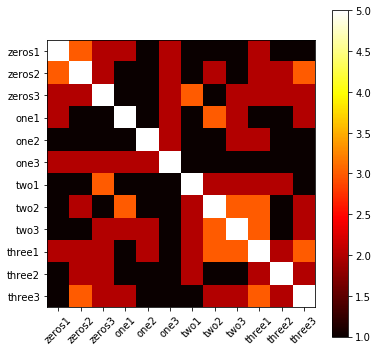

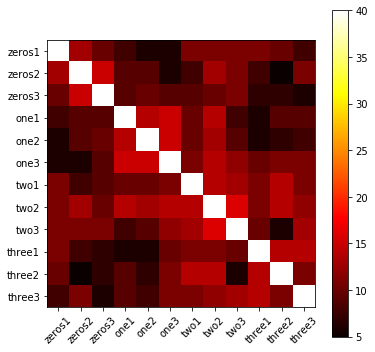

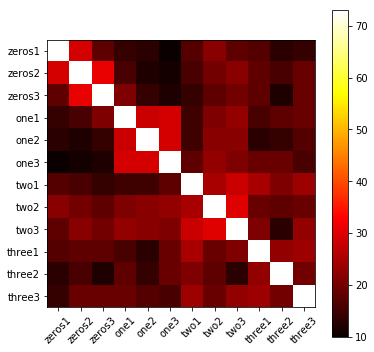

In [6]:
# Function to compute mapping matrix

def map2(list_im, k):
    m = np.zeros((len(list_im),len(list_im)))

    for i in range(len(list_im)): 
        for j in range(len(list_im)): 
            im1 = list_im[i]
            im2 = list_im[j]
            
            descriptor_extractor = ORB(n_keypoints=k)
                
            descriptor_extractor.detect_and_extract(im1)
            descriptors1 = descriptor_extractor.descriptors

            descriptor_extractor.detect_and_extract(im2)
            descriptors2 = descriptor_extractor.descriptors
            matches12 = match_descriptors(descriptors1, descriptors2)
            m[i][j] = len(matches12)
    return m

# Euclidean distance between all keypoints found 
for i in k_pts_values: 
    m = map2(list_im, i)
    plot_mapping(m, labels)

Be careful, here you have to read the inverted colors because the more matches there are between two images, the better it is contrary to the Euclidean distance.

Here the length of the descriptor also has an influence must be large enough to be able to have coherent matches. Once again, we notice that the 1 are quite similar, here the 0too, some 2 too but the three not at all. 

However, it may still be the best descriptor for the moment. 

## HoG

The idea of the HOG descriptor is that the appearance and local shape of an object in an image can be described by the "direction of the contours". This can be done by dividing the image into adjacent small regions, called cells, and calculating for each cell the histogram of gradient directions or contour orientations for the pixels within that cell.


The combination of histograms then forms the HOG descriptor. The length of the descriptor is 100x100.

La fonction dans skimage contient alors les paramètres suivants : 
- **orientations** -> Number of orientation bins
- **pixels_per_cell** -> Size (in pixels) of a cell
- **cells_per_block=(1, 1)** -> Number of cells in each block

Let's look at an example on an image : 


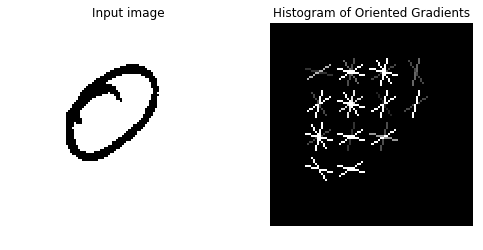

In [7]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

image = zeros1

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

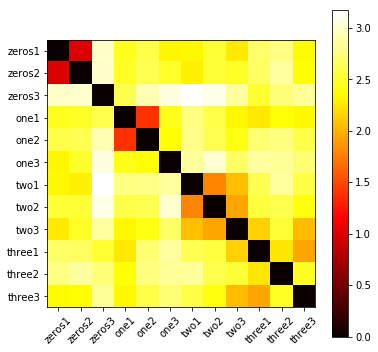

In [8]:
from skimage.feature import hog

# Function to compute mapping matrix (without reshape vector)
def mapping_v2(list_im):
    m = np.zeros((len(list_im),len(list_im)))

    for i in range(len(list_im)): 
        for j in range(len(list_im)): 
            im1 = (list_im[i])
            im2 = (list_im[j])
            m[i][j] = euclidean(im1,im2)
    return m


hog_list = []
for im in list_im: 
    hog_list.append(hog(im, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1)))
    
    
m = mapping_v2(hog_list)
plot_mapping(m, labels)

The HoG method is quite good. Even if each time, a 0 and a 1 is a problem, we still have good results on numbers that do not show any major differences. (example zeros1 and zeros2)

## Skeleton

This method consists in reducing a shape into a set of curves, called skeletons, centered in the original shape. 

The length of the descriptor is 100x100.


At first sight, it may seem that the skeleton can be a good descriptor but the figures do not lend themselves well to this kind of descriptor in view of the diversity of writing. 

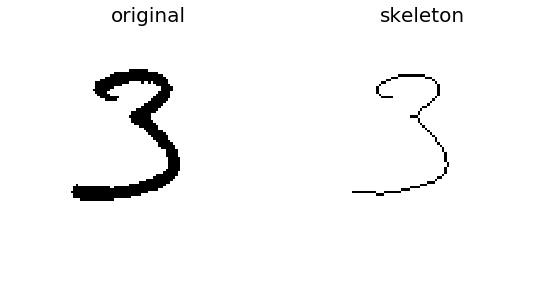

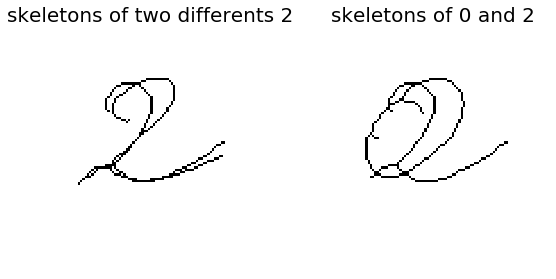

In [9]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage.filters import threshold_mean
from skimage.util import invert

# 
image = three3
thresh = threshold_mean(image)
binary = image > thresh
image = binary

# perform skeletonization
skeleton = skeletonize(invert(image))


# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(invert(skeleton), cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)


fig.tight_layout()
plt.show()



image1 = zeros1
thresh = threshold_mean(image1)
binary = image1 > thresh
image1 = binary

# perform skeletonization
skeleton1 = skeletonize(invert(image1))

image2 = two2
thresh = threshold_mean(image2)
binary = image2 > thresh
image2 = binary

# perform skeletonization
skeleton2 = skeletonize(invert(image2))

image3 = two1
thresh = threshold_mean(image3)
binary = image3 > thresh
image3 = binary

# perform skeletonization
skeleton3 = skeletonize(invert(image3))


# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(invert(skeleton3+skeleton2), cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('skeletons of two differents 2', fontsize=20)

ax[1].imshow(invert(skeleton1 + skeleton2), cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeletons of 0 and 2', fontsize=20)


fig.tight_layout()
plt.show()

Here we understand why the skeleton is not going to be a good descriptor. Indeed, the same numbers are not superposed. And on the contrary, some lines of different numbers will be perfectly superposed, which will bias the results. 

As can be seen below:  

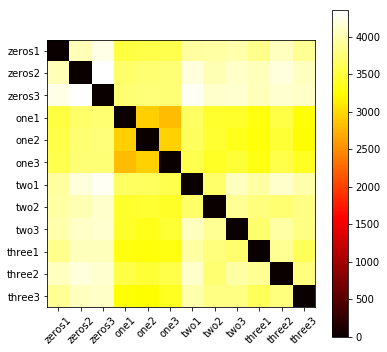

In [10]:
ske_list = []
for im in list_im: 
    image = im
    thresh = threshold_mean(image)
    binary = image > thresh
    # perform skeletonization
    skeleton = skeletonize(invert(binary))
    final_skeleton = invert(skeleton)    
    ske_list.append(final_skeleton*255)

m = mapping(ske_list)
plot_mapping(m, labels)

This method as expected is not at all suitable for our application. 

## Based on textures

### First-order statistics

Looking at the statistics on the images, we can think that it will not be a good descriptor: 
- **mean** -> length 1 
- **var** -> length 1 
- **kurtosis** -> length 100
- **skew** -> length 100


With mean :


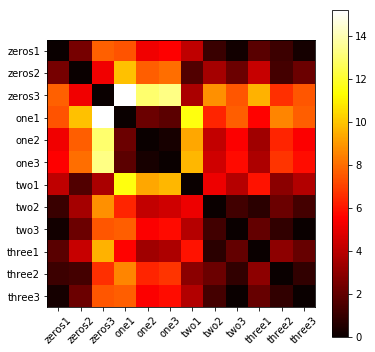

With var :


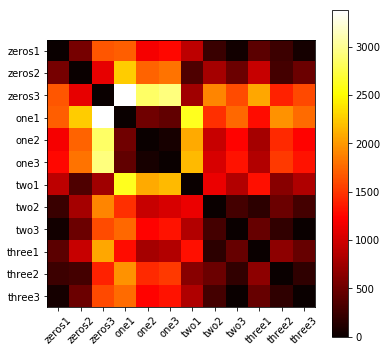

With Kurtosis : 


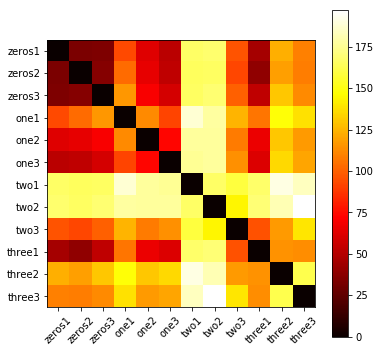

With skew :


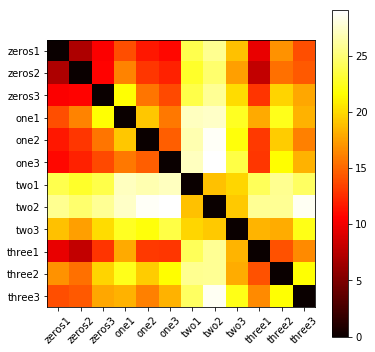

In [11]:
from scipy.stats import kurtosis, skew

#means 
means_list = []
for im in list_im: 
    mean = np.mean(im) 
    means_list.append(mean)

print('With mean :')
m_means = mapping(means_list)
plot_mapping(m_means, labels)

#var
var_list = []
for im in list_im: 
    var = np.var(im)  
    var_list.append(var)

print('With var :')
m_var = mapping(var_list)
plot_mapping(m_var, labels)

#kurtosis
kurtosis_list = []
for im in list_im: 
    kurt = kurtosis(im)
    kurtosis_list.append(kurt)

print('With Kurtosis : ')
m_kurto = mapping(kurtosis_list)
plot_mapping(m_kurto, labels)

# skew
skew_list = []
for im in list_im: 
    sk = skew(im) 
    skew_list.append(sk)

print('With skew :')
m_skew = mapping(skew_list)
plot_mapping(m_skew, labels)


When we do this kind of statistics on the whole image, it is difficult to differentiate between the 2 and 1 for example. Maybe it would have been necessary to divide the image into several cells and calculate the statistics in each cell.

### Coocurence Matrix

 The co-occurrence matrix introduced below will provide us with a first means of characterizing the periodicity and directivity of textures.

The idea is to study the texture using a texture observation window by counting the number of pairs of pixels distant from a distance that differ by a value in grayscale. In addition to the distance, the direction defined by any pair of pixels is taken into account. 

These are the different parameters in the skimage function below.

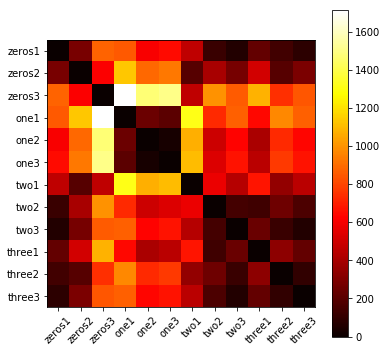

In [12]:
from skimage.feature import greycomatrix

#kurtosis
comatrix_list = []
for im in list_im: 
    comatrix = greycomatrix(np.array(im, dtype='int'), [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)
    comatrix_list.append(np.array(comatrix, dtype='double'))

m = mapping(comatrix_list)
plot_mapping(m, labels)

This descriptor does not perform well. On the observations the zero1 is close to the two and three. 
Then the two and three all seem to be close. Therefore, we do not retain this descriptor for our application.

### Gabor Filter

This filter is characterized by: 

$Gaussian * sinus/cosine = GABOR$

Gabor filters are oriented filters. They allow to highlight textures as well as homogeneous areas of an image. Thanks to the Gaussian shape of the filters, the envelopes of the filtered images provide local spectral information in each pixel. In addition, they provide information on the energy content of the image in the direction of the selected filter. 

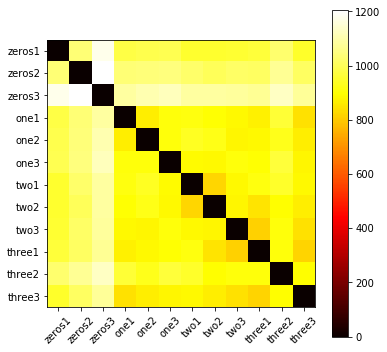

In [13]:
from skimage.filters import gabor

gabor_list = []
for im in list_im: 
    filt_real, filt_imag = gabor(im, frequency=0.6)
    gabor_list.append(filt_real)

m = mapping(gabor_list)
plot_mapping(m, labels)

The Gabor filter is too strict, i.e. no figures seem close, they are all very far from each other. 

### Local Binary Pattern (LBP) 

For each pixel p, create an 8-bit number $b_{1}$ $b_{2}$ $b_{3}$ $b_{4}$ $b_{5}$ $b_{6}$ $b_{7}$ $b_{8}$, where $b_{i} = 0$ if neighbor $i$ has value less tan or equal to p's value and 1 otherwise.

This histogram will be the vector representing the image.

This method represnets the texture in the image by the histogram of these number. 

I choose the parameters $P=8$ and $R=1$ 


(source : slideshow Local Binary Pattern, Mrs. Petitjean) 

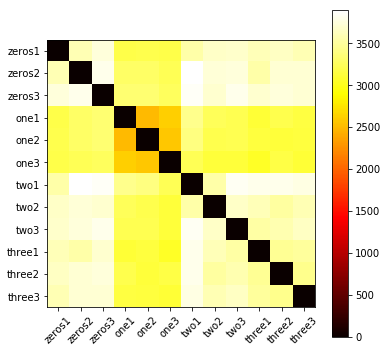

In [14]:
from skimage.feature import local_binary_pattern

LBP_list = []
for im in list_im: 
    lbp = local_binary_pattern(im, P=8, R=1)
    LBP_list.append(lbp)

m = mapping(LBP_list)
plot_mapping(m, labels)

This descriptor works for all 1 but otherwise it is not good.

## Conclusion : 


- If we have enough data, it's better to use deep-learning and if not, if there is not a lot of data like here, HoG or the number of matches with ORB can be quite a bit of a descriptor, even if there are still some problem cases.  

- Regarding the length of the descriptor, our two most successful descriptors have different lengths. HoG has 100x100 variables while the number of matches is between 5 and 40. 

## Fashion

For this part, I will perform the same descriptors as the digits part (so I will not explain all the methods again). I'm just going to interpret all the results. 

### Pixel intensity 

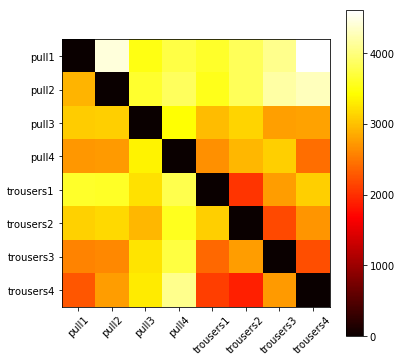

In [15]:
images = [f for f in listdir('fashion/') if isfile(join('fashion/', f))]

l = []
for im in images:
    ima = io.imread('fashion/' + im)
    image = ima[:,:,0]
    #image = seuillage(image, 0.5)
    l.append(image)

    
pull1 = l[1]; pull2 = l[6]; pull3= l[0]; pull4 = l[7]
trousers1 = l[5]; trousers2 = l[4]; trousers3 = l[3]; trousers4 = l[2]


list_im = [pull1, pull2, pull3, pull4, trousers1, trousers2, trousers3, trousers4]

labels = ['pull1', 'pull2', 'pull3', 'pull4', 'trousers1', 'trousers2', 'trousers3', 'trousers4']
m = mapping(list_im)
plot_mapping(m, labels)

Again, pixel intensity is not a good descriptor. 

### ORB

This method does not work because the resolution of the images is too low. 

In [16]:
from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

k_pts_values = [2]

for i in k_pts_values: 
    img1 = pull1
    img2 = pull2
    img3 = trousers1

    descriptor_extractor = ORB(n_keypoints=i)

    descriptor_extractor.detect_and_extract(img1)
    keypoints1 = descriptor_extractor.keypoints
    descriptors1 = descriptor_extractor.descriptors

    descriptor_extractor.detect_and_extract(img2)
    keypoints2 = descriptor_extractor.keypoints
    descriptors2 = descriptor_extractor.descriptors

    descriptor_extractor.detect_and_extract(img3)
    keypoints3 = descriptor_extractor.keypoints
    descriptors3 = descriptor_extractor.descriptors

    matches12 = match_descriptors(descriptors1, descriptors2, metric='euclidean')
    matches13 = match_descriptors(descriptors1, descriptors3, metric='euclidean')


    fig, ax = plt.subplots(nrows=1, ncols=2)

    plt.gray()
    print('With ' + str(i) + ' keypoints :')

    plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
    ax[0].axis('off')

    plot_matches(ax[1], img1, img3, keypoints1, keypoints3, matches13)
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()
    
    print(str(len(matches12)) + ' matches\t\t\t' + str(len(matches13)) + ' matches\n\n')

RuntimeError: ORB found no features. Try passing in an image containing greater intensity contrasts between adjacent pixels.

### HoG

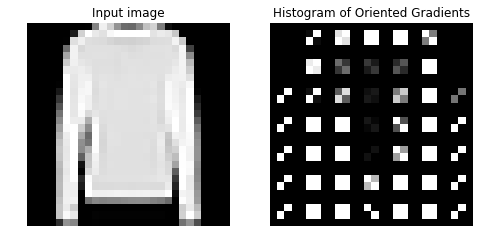

In [17]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

image = pull1

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

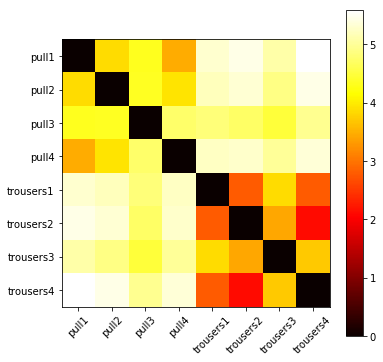

In [18]:
hog_list = []
for im in list_im: 
    hog_list.append(hog(im, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1)))
    
m = mapping_v2(hog_list)
plot_mapping(m, labels)

The trousers seem close in terms of distance and rather far from the sweaters so HoG is performing well on this point.
We can explain this with the shape of the trousers, with the separation of the legs, the descriptor is able to "reunite" the trousers between them. 

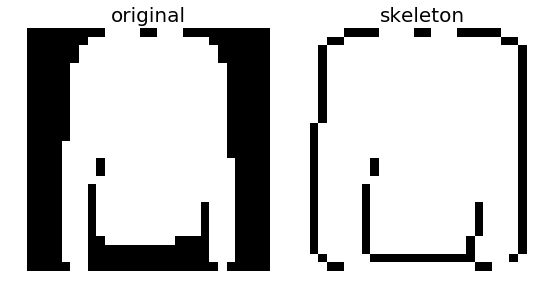

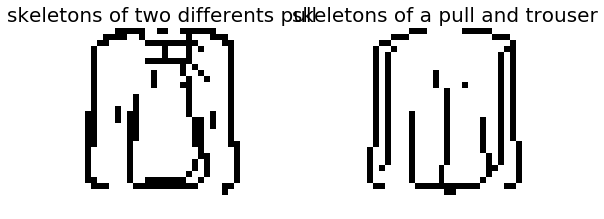

In [19]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage.filters import threshold_mean
from skimage.util import invert

# 
image = pull1
thresh = threshold_mean(image)
binary = image > thresh
image = binary

# perform skeletonization
skeleton = skeletonize(invert(image))


# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(invert(skeleton), cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)


fig.tight_layout()
plt.show()



image1 = trousers2
thresh = threshold_mean(image1)
binary = image1 > thresh
image1 = binary

# perform skeletonization
skeleton1 = skeletonize(invert(image1))

image2 = pull2
thresh = threshold_mean(image2)
binary = image2 > thresh
image2 = binary

# perform skeletonization
skeleton2 = skeletonize(invert(image2))

image3 = pull4
thresh = threshold_mean(image3)
binary = image3 > thresh
image3 = binary

# perform skeletonization
skeleton3 = skeletonize(invert(image3))


# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(invert(skeleton3+skeleton2), cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('skeletons of two differents pull', fontsize=20)

ax[1].imshow(invert(skeleton1 + skeleton2), cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeletons of a pull and trouser', fontsize=20)


fig.tight_layout()
plt.show()

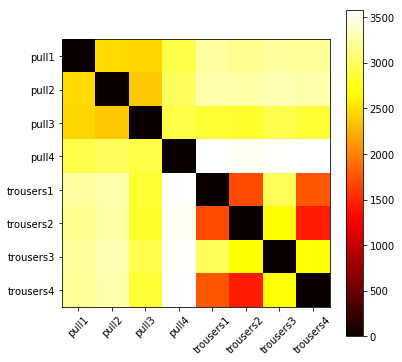

In [20]:
ske_list = []
for im in list_im: 
    image = im
    thresh = threshold_mean(image)
    binary = image > thresh
    # perform skeletonization
    skeleton = skeletonize(invert(binary))
    final_skeleton = invert(skeleton)    
    ske_list.append(final_skeleton*255)

m = mapping(ske_list)
plot_mapping(m, labels)

The skeleton also seems to be quite good. Indeed, this can still be explained by the shape of the clothes with the separation of the legs for the trousers.  

With mean :


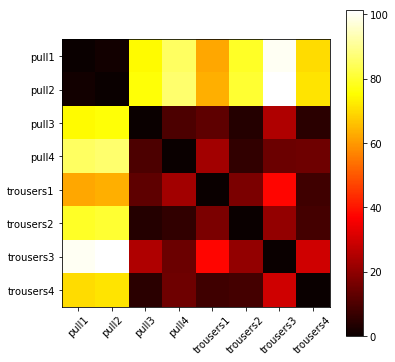

With var :


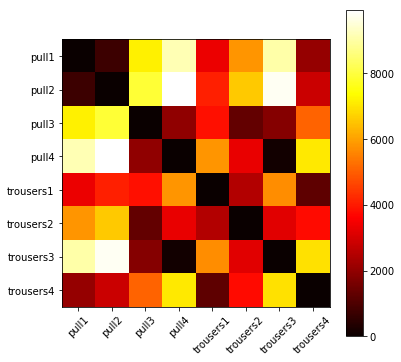

With Kurtosis : 


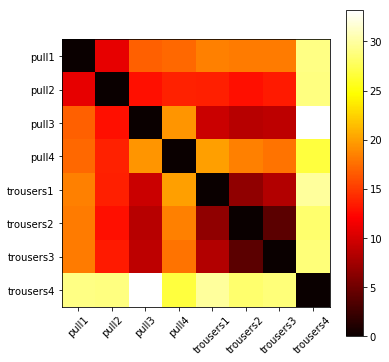

With skew :


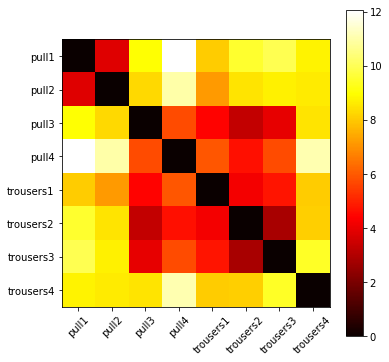

In [21]:
from scipy.stats import kurtosis, skew

#means 
means_list = []
for im in list_im: 
    mean = np.mean(im) 
    means_list.append(mean)

print('With mean :')
m_means = mapping(means_list)
plot_mapping(m_means, labels)

#var
var_list = []
for im in list_im: 
    var = np.var(im)  
    var_list.append(var)

print('With var :')
m_var = mapping(var_list)
plot_mapping(m_var, labels)

#kurtosis
kurtosis_list = []
for im in list_im: 
    kurt = kurtosis(im)
    kurtosis_list.append(kurt)

print('With Kurtosis : ')
m_kurto = mapping(kurtosis_list)
plot_mapping(m_kurto, labels)

# skew
skew_list = []
for im in list_im: 
    sk = skew(im) 
    skew_list.append(sk)

print('With skew :')
m_skew = mapping(skew_list)
plot_mapping(m_skew, labels)

The stats are bad descriptors. 

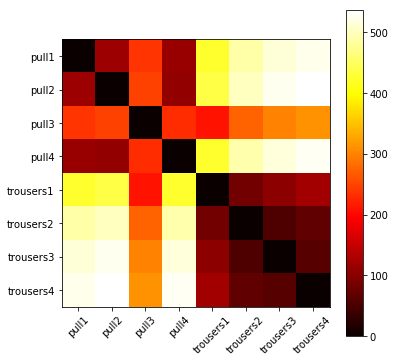

In [22]:
from skimage.feature import greycomatrix

#kurtosis
comatrix_list = []
for im in list_im: 
    comatrix = greycomatrix(np.array(im, dtype='int'), [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)
    comatrix_list.append(np.array(comatrix, dtype='double'))

m = mapping(comatrix_list)
plot_mapping(m, labels)

The coocurence matrix seems to be a very good descriptor. We have the items of the same category very close level distance. (Pull3 is the only problem case)

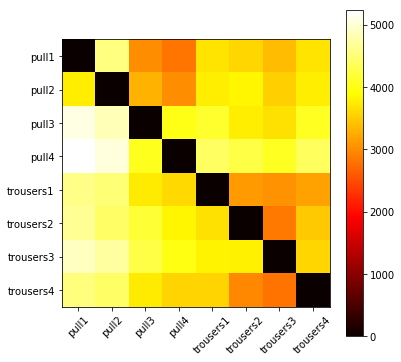

In [23]:
from skimage.filters import gabor

gabor_list = []
for im in list_im: 
    filt_real, filt_imag = gabor(im, frequency=0.6)
    gabor_list.append(filt_real)

m = mapping(gabor_list)
plot_mapping(m, labels)

The Gabor filter is not enough separator, and is not suitable for our images.  

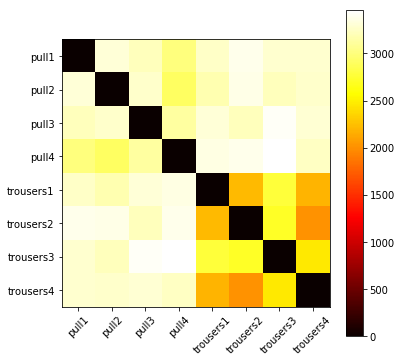

In [24]:
from skimage.feature import local_binary_pattern

LBP_list = []
for im in list_im: 
    lbp = local_binary_pattern(im, P=8, R=1)
    LBP_list.append(lbp)

m = mapping(LBP_list)
plot_mapping(m, labels)

LBP works pretty well for trousers but not too well for pull. 

### CONCLUSION

- In the case of clothing, the length of our best descriptors is the same, i.e. the size of the image (here 28x28)
